Дисперсия, объяснённая PCA: 45.63%


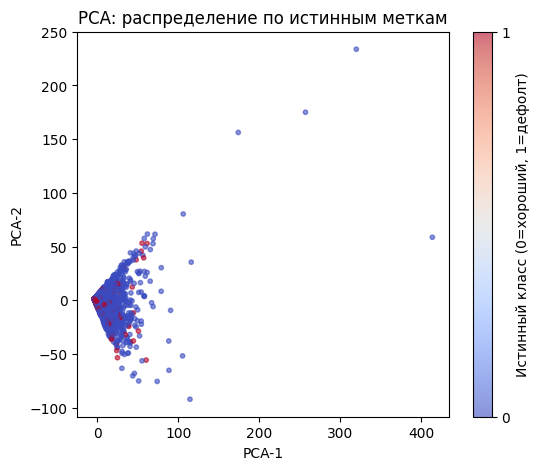

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    confusion_matrix,
    silhouette_score
)
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

url = 'https://raw.githubusercontent.com/ARBUZNIJ/ML_2025/refs/heads/master/UCI_Credit_Card.csv'
data_raw = pd.read_csv(url)

target_col = 'default.payment.next.month'
X = data_raw.drop(columns=[target_col])
y = data_raw[target_col]

def fix_categories(df):
    df = df.copy()
    df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)
    df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)
    return df

X = fix_categories(X)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Дисперсия, объяснённая PCA: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, ticks=[0, 1], label='Истинный класс (0=хороший, 1=дефолт)')
plt.title('PCA: распределение по истинным меткам')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

1)Нет четкого разделения классов. На графике видно, что точки синего и красного цвета сильно перемешаны. Нет такой области на плоскости, где бы были только синие точки, а в другой — только красные. Это означает, что даже в упрощенном (сниженном до 2D) пространстве признаков, которое объясняет почти половину дисперсии данных (45.63%), не существует простого линейного или геометрического правила, по которому можно было бы отделить дефолтных клиентов от хороших.


2)Классы перекрываются. Большая часть "дефолтных" клиентов (красные точки) находится в той же плотной группе, что и "хорошие" клиенты (синие точки). Только небольшое количество "дефолтных" клиентов (около 10-15%) выделяется в виде более рассеянных точек в правой части графика (при высоких значениях PCA-1). Задача является сложной для классификации, так как признаки не позволяют однозначно разделить объекты по целевому классу.

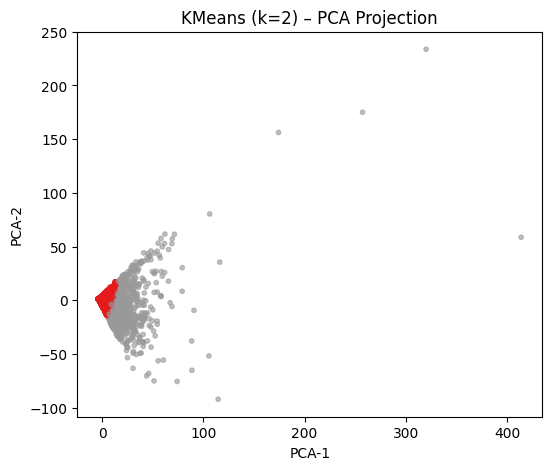

KMeans (k=5):
  ARI = -0.0295
  NMI = 0.0071
Confusion matrix (rows = истинные, cols = кластеры):
[[22180  1184]
 [ 6511   125]]


In [7]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='Set1', alpha=0.6, s=10)
plt.title('KMeans (k=2) – PCA Projection')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

ari_kmeans = adjusted_rand_score(y, labels_kmeans)
nmi_kmeans = normalized_mutual_info_score(y, labels_kmeans)
print(f"KMeans (k=5):\n  ARI = {ari_kmeans:.4f}\n  NMI = {nmi_kmeans:.4f}")
print("Confusion matrix (rows = истинные, cols = кластеры):")
print(confusion_matrix(y, labels_kmeans))

1)Кластеры не соответствуют истинным классам. Красный кластер (кластер 1), который KMeans выделил в левом нижнем углу, состоит почти исключительно из "хороших" клиентов (класс 0). Это видно из матрицы ошибок: в этом кластере всего 1184 "дефолтных" клиента (класс 1) против 22180 "хороших" (класс 0). То есть, если бы мы использовали этот кластер как сигнал для "риска дефолта", мы бы ошибались в огромном количестве случаев.

2)Очень низкие метрики согласованности.

  - ARI = -0.0295: Отрицательное значение Adjusted Rand Index означает, что разбиение на кластеры хуже, чем случайное. Истинные метки и метки кластеров практически не связаны.
  - NMI = 0.0071: Normalized Mutual Information близко к нулю, что подтверждает отсутствие взаимной информации между кластерами и истинными классами.

Алгоритм нашел геометрическую структуру, а не смысловую. KMeans стремится минимизировать внутрикластерную дисперсию. Он успешно нашел самую плотную область данных (левый нижний угол) и выделил её в отдельный кластер. Однако эта плотная область по сути представляет собой основную массу "хороших" клиентов, а не группу "дефолтных". Алгоритм просто нашел "сгусток" точек, но этот сгусток не имеет отношения к целевой переменной.

**Вывод:** Этот результат наглядно демонстрирует неэффективность KMeans для данной задачи. Метод, будучи полностью необученным (без учителя), не способен распознать скрытую структуру, которая определяет дефолт. Он выделяет кластеры на основе пространственной близости, а не на основе предиктивной силы признаков для целевой переменной. Для решения задачи прогнозирования дефолта необходимо использовать методы обучения с учителем, которые могут учиться на истинных метках и находить сложные, нелинейные зависимости между признаками и целевой переменной.

DBSCAN: 30 кластеров, 11967 выбросов


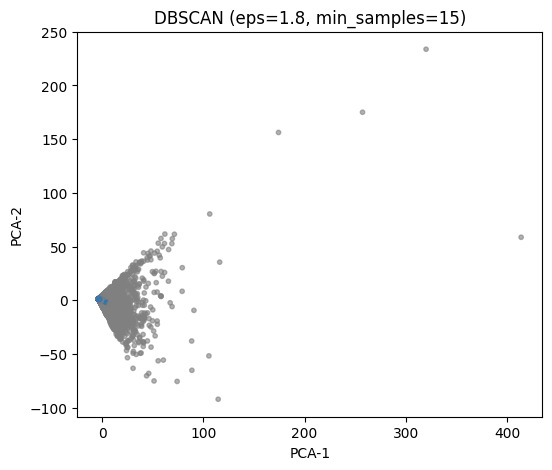

DBSCAN:
  ARI = 0.0667
  NMI = 0.0373


In [10]:
# Подбор eps для DBSCAN
nn = NearestNeighbors(n_neighbors=5)
nbrs = nn.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, -1], axis=0)[::-1]

'''plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.title('K-distance plot (k=5) → выбор eps ≈ "локоть"')
plt.xlabel('Объекты (по убыванию dist)')
plt.ylabel('5-е расстояние до соседа')
plt.grid()
plt.show()

# Выбираем eps ≈ 1.5–2.0 (по графику — "локоть")'''
eps = 1.8
min_samples = 15
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
labels_dbscan = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)
print(f"DBSCAN: {n_clusters_dbscan} кластеров, {n_noise} выбросов")

plt.figure(figsize=(6, 5))
colors = ['gray' if label == -1 else plt.cm.tab10(label % 10) for label in labels_dbscan]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=10, alpha=0.6)
plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples})')
plt.xlabel('PCA-1'); plt.ylabel('PCA-2')
plt.show()

ari_dbscan = adjusted_rand_score(y, labels_dbscan)
nmi_dbscan = normalized_mutual_info_score(y, labels_dbscan)
print(f"DBSCAN:\n  ARI = {ari_dbscan:.4f}\n  NMI = {nmi_dbscan:.4f}")
#print("Confusion matrix:")
#print(confusion_matrix(y, labels_dbscan))

DBSCAN нашел 30 отдельных кластеров.
Более трети всех клиентов (11967 из 30000) были помечены как выбросы (шум) и не включены ни в один кластер.

Визуализация PCA: На графике серые точки — это выбросы, а красные/синие — точки, входящие в кластеры. Видно, что основная масса данных (серые точки) образует одно большое облако, а кластеры выделяются как небольшие группы внутри или вокруг него.

ARI = 0.0667, NMI = 0.0373: Эти значения, хотя и положительные, все еще очень низкие. Они подтверждают вывод: кластеры, найденные DBSCAN, не имеют значимой связи с истинными метками классов (дефолт/не дефолт). Несмотря на то, что DBSCAN смог найти структуру в данных (30 кластеров), эта структура не соответствует целевой переменной.

Таким образом, результаты DBSCAN подтверждают общий вывод: использование кластеризации без учителя для решения задачи прогнозирования дефолта в данном случае неэффективно.

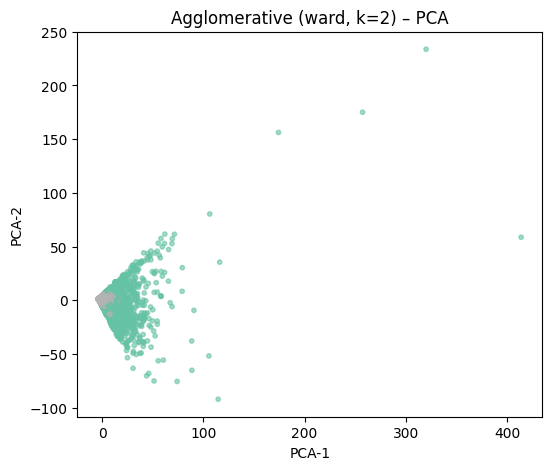

Agglomerative (k=2):
  ARI = -0.0394
  NMI = 0.0084
Confusion matrix:
[[ 2024 21340]
 [  252  6384]]


In [12]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_agglo = agglo.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_agglo, cmap='Set2', alpha=0.6, s=10)
plt.title('Agglomerative (ward, k=2) – PCA')
plt.xlabel('PCA-1'); plt.ylabel('PCA-2')
plt.show()

ari_agglo = adjusted_rand_score(y, labels_agglo)
nmi_agglo = normalized_mutual_info_score(y, labels_agglo)
print(f"Agglomerative (k=2):\n  ARI = {ari_agglo:.4f}\n  NMI = {nmi_agglo:.4f}")
print("Confusion matrix:")
print(confusion_matrix(y, labels_agglo))

Алгоритм выделил два кластера по геометрическому признаку. Как и KMeans, Agglomerative Clustering стремится минимизировать внутрикластерную дисперсию. Он нашел самую плотную область данных (левый нижний угол) и выделил ее в отдельный кластер (зеленый), а все остальные точки отнес к другому кластеру (серый).

Кластеры не соответствуют истинным классам.

Очень низкие метрики согласованности.

**Вывод:** Этот результат аналогичен результатам KMeans. Алгоритм иерархической кластеризации также не смог найти кластеры, которые бы соответствовали целевой переменной (дефолт/не дефолт). Он успешно выделил геометрически плотные области, но эти области не имеют отношения к риску дефолта.

Кластеризация без учителя неэффективна для прогноза дефолта в этом датасете.
Ни KMeans, ни DBSCAN, ни Agglomerative Clustering не смогли выделить кластеры, близкие к истинным классам (дефолт/не дефолт).
→ ARI ≈ –0.04…+0.07, NMI ≈ 0.007–0.037 — близко к случайному уровню.
Причиной является структура данных:
Классы сильно пересекаются в признаковом пространстве (визуализация PCA это ясно демонстрирует).

Задача — классификационная, а не кластеризационная по своей природе.
Использовать обучение без учителя для прогноза дефолта нецелесообразно. Методы обучения с учителем, как видно из работы номер 3, работают лучше (но тоже не идеально - отчасти по тем же причинам)